In [1]:
# Comments for running on Colab
# !apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
# !pip install rmjarvis.eigency>=1.77.1
# !pip install galsim --no-cache-dir
# !pip install scikit-image

import pytest
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import galsim
%pylab inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from learnlets.learnlet_model import Learnlet
from learnlets.keras_utils.normalisation import NormalisationAdjustment
from learnlets.learned_wavelet import learnlet
from tensorflow.keras.optimizers import Adam
from evaluate import keras_psnr, keras_ssim, center_keras_psnr

print(tf.test.gpu_device_name()) 

Populating the interactive namespace from numpy and matplotlib
runstats and/or skimage could not be imported because not installed
/device:GPU:0


In [5]:
dataset = np.load('datasets/dataset_45_64.npy',allow_pickle='TRUE').item()

im_train, im_val, target_train, target_val = train_test_split(dataset['VIGNETS_WITH_NOISE'], dataset['VIGNET_NOISELESS'], 
                                                              shuffle=False, stratify=None, test_size=0.2, random_state=10)

im_train, target_train = shuffle(im_train, target_train)

im_train = (tf.reshape(tf.convert_to_tensor(im_train), [36000, 64, 64, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [36000, 64, 64, 1])
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [9000, 64, 64, 1]))
target_val = tf.reshape(tf.convert_to_tensor(target_val), [9000, 64, 64, 1])

In [ ]:
## Test with learnlets

run_params = {
    'learnlet_analysis_kwargs':{
        'n_tiling': 256, 
        'mixing_details': False,        
    },
    'learnlet_synthesis_kwargs': {
        'res': False,
    },
    'n_scales': 5,
    'clip': False,
}

n_channels = 1
model=learnlet(input_size=(64,64,n_channels), lr=1e-3, **run_params)
print(model.summary())

In [8]:
history = model.fit(im_train, target_train, validation_data=(im_val, target_val), batch_size=12, 
           epochs=500, steps_per_epoch=200)

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss of the Learnlets on the PSF Dataset')
plt.ylabel('Loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

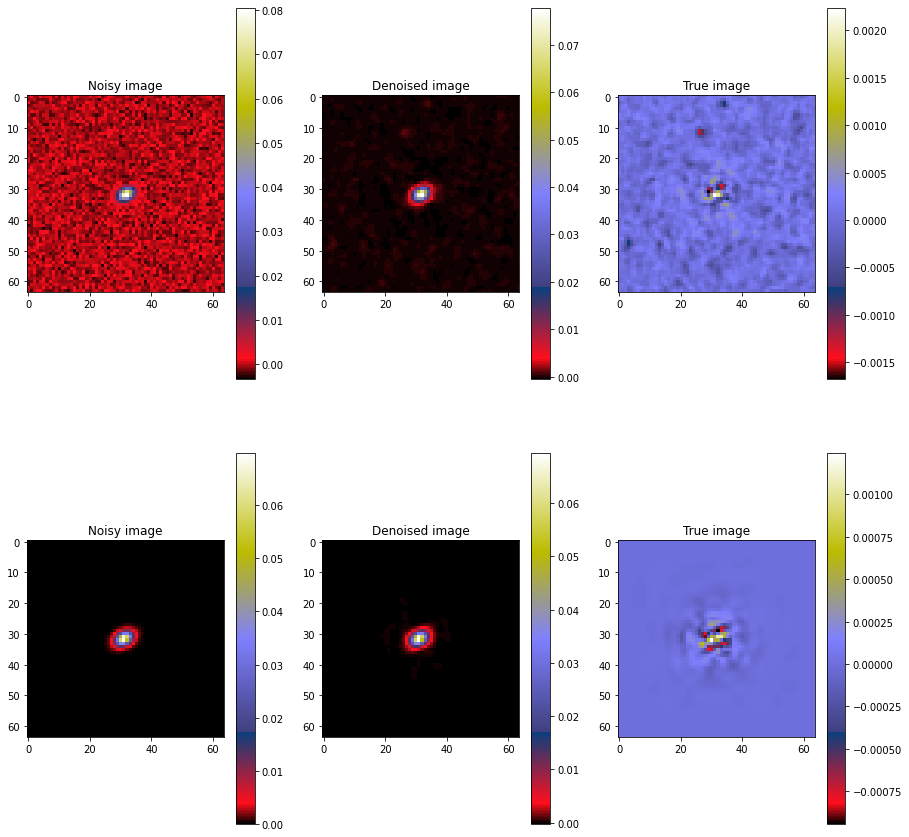

In [20]:
one_star_noiseless = tf.reshape(model.predict(im_val)[180,:,:], [64, 64])
one_star_truth = tf.reshape(tf.convert_to_tensor(target_val[180,:,:]), [64, 64])
one_star_noiseless = tf.cast(one_star_noiseless, one_star_truth.dtype)
one_star_noise = tf.reshape(tf.convert_to_tensor(im_val[180,:,:]), [64, 64])
second_star_noiseless = tf.reshape(model.predict(im_val)[179,:,:], [64, 64])
second_star_truth = tf.reshape(tf.convert_to_tensor(target_val[179,:,:]), [64, 64])
second_star_noiseless = tf.cast(second_star_noiseless, second_star_truth.dtype)
second_star_noise = tf.reshape(tf.convert_to_tensor(im_val[179,:,:]), [64, 64])



fig = plt.figure(num=0, figsize=(15,15))
subplot(231)
title('Noisy image')
imshow(one_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(232)
#imshow(one_star_noiseless-one_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(233)
imshow(one_star_truth-one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('True image')
subplot(234)
title('Noisy image')
imshow(second_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(235)
#imshow(second_star_noiseless-second_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(second_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(236)
imshow(second_star_truth-second_star_noiseless, interpolation='None', cmap='gist_stern');colorbar()
title('True image')
show()

In [22]:
diff_e1_HSM = np.zeros(im_val.shape[0])
diff_e2_HSM = np.zeros(im_val.shape[0])
diff_R2_HSM = np.zeros(im_val.shape[0])
e1_HSM_measured = np.zeros(im_val.shape[0])
e2_HSM_measured = np.zeros(im_val.shape[0])
R2_HSM_measured = np.zeros(im_val.shape[0])
e1_HSM_true = np.zeros(im_val.shape[0])
e2_HSM_true = np.zeros(im_val.shape[0])
R2_HSM_true = np.zeros(im_val.shape[0])
predictions = model.predict(im_val)
for it in range(im_val.shape[0]):
  my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(np.reshape(predictions[it], (64,64))))
  diff_e1_HSM[it] = my_moments.observed_shape.g1-dataset['TRUE_E1_HSM'][36000+it]
  diff_e2_HSM[it] = my_moments.observed_shape.g2-dataset['TRUE_E2_HSM'][36000+it]
  diff_R2_HSM[it] = my_moments.moments_sigma-dataset['TRUE_R2_HSM'][36000+it]
  e1_HSM_measured[it] = my_moments.observed_shape.g1
  e2_HSM_measured[it] = my_moments.observed_shape.g2
  R2_HSM_measured[it] = my_moments.moments_sigma
  e1_HSM_true[it] = dataset['TRUE_E1_HSM'][36000+it]
  e2_HSM_true[it] = dataset['TRUE_E2_HSM'][36000+it]
  R2_HSM_true[it] = dataset['TRUE_R2_HSM'][36000+it]
  
  print(it)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
41

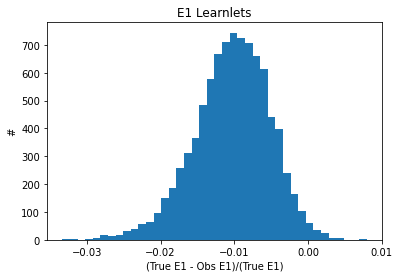

In [63]:
hist(diff_e1_HSM, bins=40)
pyplot.title('E1 Learnlets')
plt.ylabel("#")
plt.xlabel("(True E1 - Obs E1)/(True E1)")
plt.savefig("e1_learnlets.png")

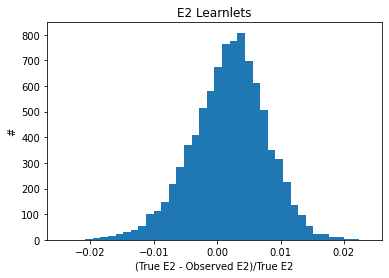

In [64]:
hist(diff_e2_HSM, bins=40)
pyplot.title('E2 Learnlets')
plt.ylabel("#")
plt.xlabel("(True E2 - Observed E2)/True E2")
plt.savefig("e2_learnlets.png")

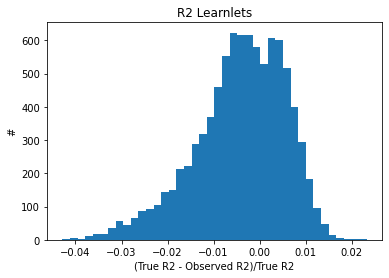

In [66]:
hist(-diff_R2_HSM/R2_HSM_true, bins=40)
pyplot.title('R2 Learnlets')
plt.ylabel("#")
plt.xlabel("(True R2 - Observed R2)/True R2")
plt.savefig("R2_learnlets.png")

In [67]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(e1_HSM_measured, e1_HSM_true, squared=False))
print(mean_squared_error(e2_HSM_measured, e2_HSM_true, squared=False))
print(mean_squared_error(R2_HSM_measured, R2_HSM_true, squared=False))

0.011527922709724499
0.006186504173417264
0.01548053313651491


In [68]:
print(mean(diff_e1_HSM))
print(mean(diff_e2_HSM))
print(mean(diff_R2_HSM))

-0.010326899471383206
0.0018719107031547363
0.004839349680476718


In [8]:
model.save('learnlets')

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847ac410>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847ac410>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8472bf90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8472bf90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84791490>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84791490>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c0950>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c0950>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84775510>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84775510>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ce310>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ce310>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847de5d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847de5d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846dac90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846dac90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847ac410>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847ac410>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8472bf90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8472bf90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84791490>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84791490>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c0950>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c0950>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84775510>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84775510>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ce310>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ce310>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847de5d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847de5d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846dac90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846dac90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84739650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8471c290>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84723650>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847473d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84727bd0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8479c690>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847ac410>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847ac410>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8472bf90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe8472bf90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84783710>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ba590>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84791490>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84791490>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c0950>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c0950>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847e7790>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846c4f10>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84775510>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe84775510>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ce310>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 8, 8, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846ce310>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846cd8d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847cd850>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847de5d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe847de5d0>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846dac90>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name='x'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efe846dac90>), {}).


INFO:tensorflow:Assets written to: learnlets/assets


INFO:tensorflow:Assets written to: learnlets/assets


In [57]:
test=[x for x in -diff_e2_HSM/e2_HSM_true if abs(x) <= 1]

In [61]:
len(test)

8400